### Example: Priors on function spaces
https://predictivesciencelab.github.io/data-analytics-se/lecture21/hands-on-21.html

In [32]:
import warnings

warnings.simplefilter("ignore")

import numpy as np

import torch



import gpytorch
from gpytorch.means import ConstantMean



from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel



import matplotlib.pyplot as plt


import seaborn as sns

#### Squared exponential covariance function
GPytorch implements this covariance function as a composition of two kernels: RBFKernel and ScaleKernel.

plot kernel function

In [19]:
def plot_kernel(k):
    """Plot the covariance function."""
    fig, ax = plt.subplots()
    x = torch.linspace(-4, 4, 200)[:, None]
    zero = torch.zeros(1)[:, None]
    ks = k.forward(zero, x)
    ax.plot(x, ks.detach().T)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$k(0,x)$")
    sns.despine(trim=True)

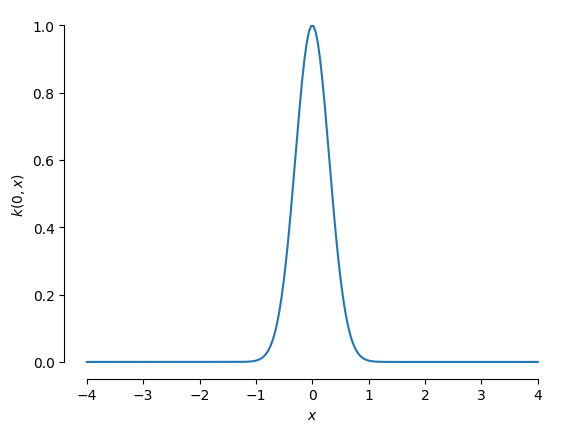

In [20]:
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.3
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the lengthscale ?

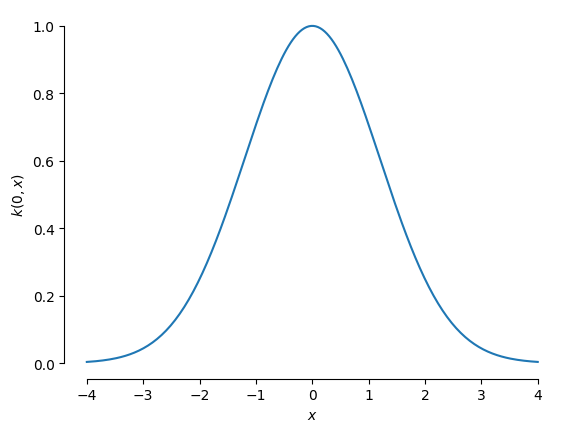

In [21]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 1.0
plot_kernel(k)

What happens as you increase the variance ?

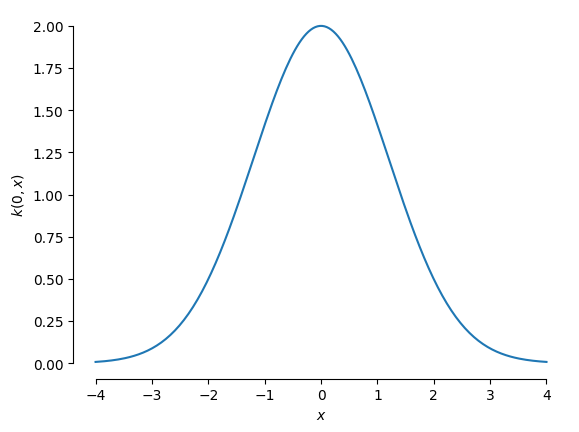

In [22]:
k.base_kernel.lengthscale = 1.2
k.outputscale = 2.0
plot_kernel(k)

plot maternKernel

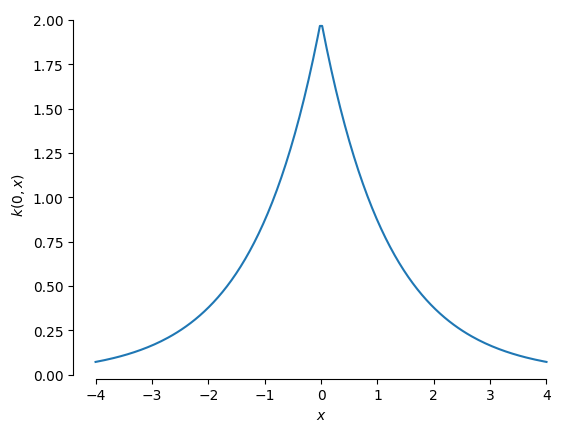

In [25]:
k1 = ScaleKernel(MaternKernel(nu=0.5))
k1.base_kernel.lengthscale = 1.2
k1.outputscale = 2.0
plot_kernel(k1)

#### Verify that the properties of covariance functions

covariance function must be positive definite

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
C:\Users\yangx\AppData\Local\Temp\ipykernel_11716\3859068568.py:16: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_{i}$")


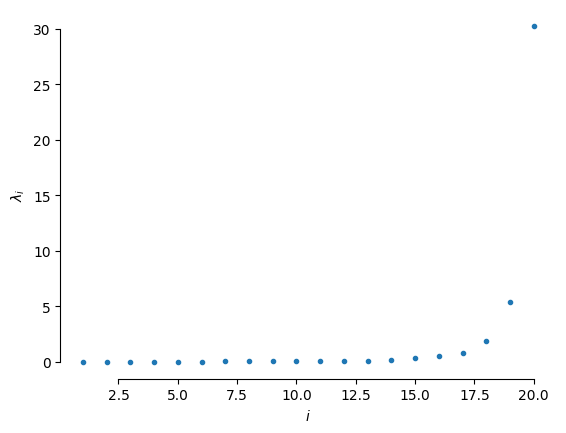

In [31]:
k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1

n = 20

X = torch.rand(n, 1)
K = k1.forward(X, X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = torch.linalg.eigh(K)

fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_{i}$")
sns.despine(trim=True)

sum of covariance functions

In [36]:
k1 = ScaleKernel(RBFKernel())
k1.base_kernel.lengthscale = 0.3
k1.outputscale = 1.0

k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 1
k2.outputscale = 1.5

k_new = k1 + k2

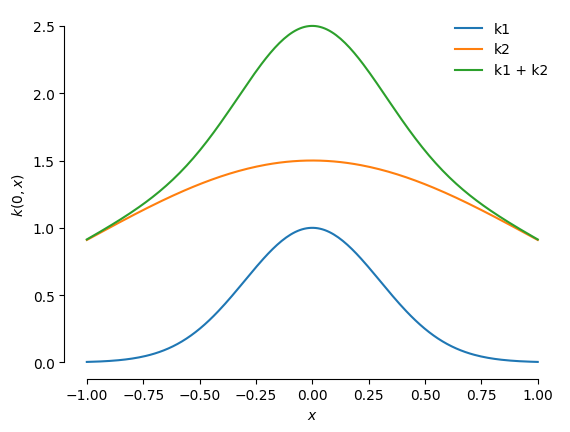

In [37]:
fig, ax = plt.subplots()
x = torch.linspace(-1, 1, 200)[:, None]
zero = torch.zeros(1)[:, None]
ks1 = k1.forward(zero, x)
ks2 = k2.forward(zero, x)
ks_new = k_new.forward(zero, x)
ax.plot(x, ks1.detach().T, label="k1")
ax.plot(x, ks2.detach().T, label="k2")
ax.plot(x, ks_new.detach().numpy().T, label="k1 + k2")
ax.set_xlabel("$x$")
ax.set_ylabel("$k(0,x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\yangx\AppData\Local\Temp\ipykernel_11716\3485106429.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_i$")


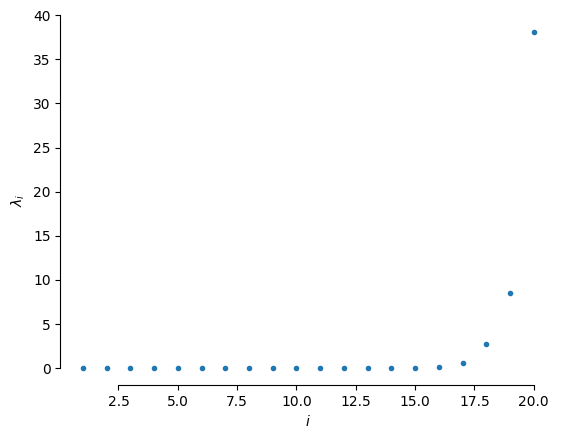

In [38]:
K_new = k_new.forward(X, X)
eig_val, eig_vec = torch.linalg.eigh(K_new)
fig, ax = plt.subplots()
ax.plot(np.arange(1, n + 1), eig_val.detach(), ".")
ax.set_xlabel("$i$")
ax.set_ylabel("$\lambda_i$")
sns.despine(trim=True)

#### Sampling from a Gaussian process

we only need to know how to sample from the multivariate normal:

$$\mathbf{f}|\mathbf{x}_{1:n}\sim\mathcal{N}(\mathbf{m}(\mathbf{x}_{1:n}),\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}))$$

1. Compute the Cholesky of $\mathbf{L}$:
$$\mathbf{K}=\mathbf{L}\mathbf{L}^T$$
2. Draw n random samples $z$ independently from a standard normal.
3. Get one sample by:
$$\mathbf{f}=\mathbf{m}+\mathbf{Lz}.$$

In [54]:
def sample_functions(mean_func, kernel_func, num_samples=5, num_test=20, nugget=1e-5):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label="mean")
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5, label="sample" if i == 0 else None)
    plt.legend(loc="best", frameon=False)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_ylim(-3, 3)
    sns.despine(trim=True)

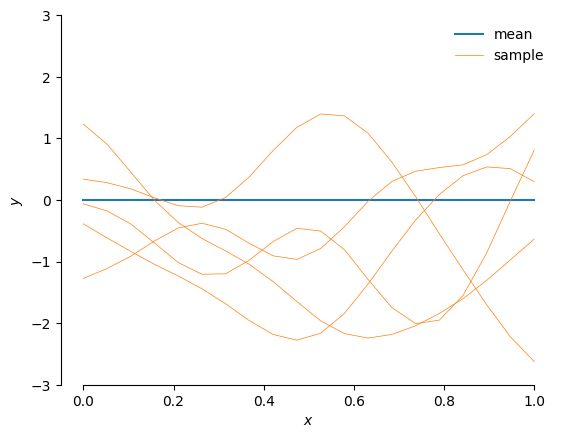

In [57]:
from gpytorch.means import ConstantMean, LinearMean

torch.manual_seed(123)

k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0

mean_func = ConstantMean()

sample_functions(mean_func, k)

effects of the lengthscale

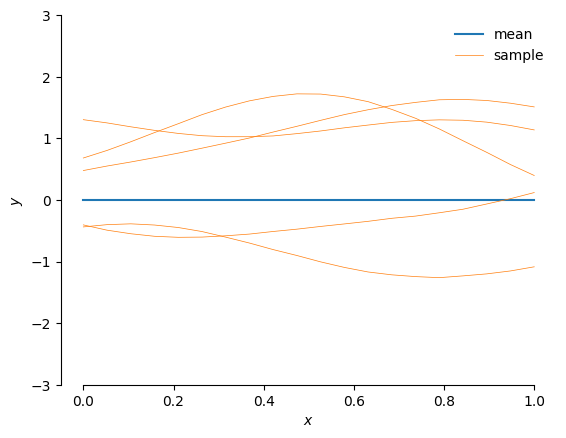

In [58]:
mean_func = ConstantMean()
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.5
k.outputscale = 1.0
sample_functions(mean_func, k)

##### effects of mean function
Let’s do a linear mean function:
$$m(x) = ax+b$$

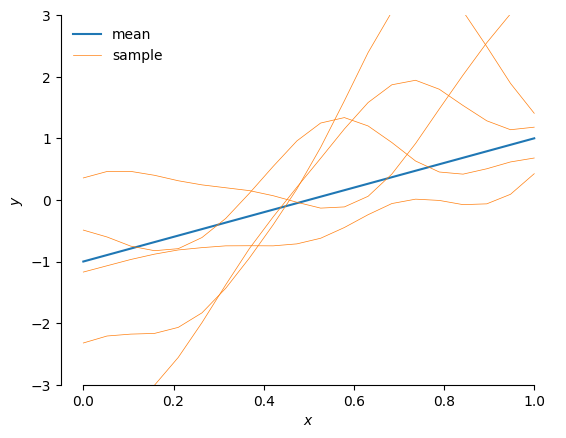

In [63]:
a = 2.0
b = -1.0
mean_func = LinearMean(input_size=1)
mean_func.weights = torch.nn.Parameter(torch.tensor([a]))
mean_func.bias = torch.nn.Parameter(torch.tensor([b]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

Let’s use a mean function that is not in the GPytorch library. We will the mean function:
$$m(x)=a\sin(\omega x)$$
We need to inherit from the `gpytorch.means.Mean` class and implement the `forward` method:

In [64]:
class MyMean(torch.nn.Module):
    """A custom mean function."""

    def __init__(self, batch_shape=torch.Size()):
        super().__init__()
        self.register_parameter("a", torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        self.register_parameter("omega", torch.nn.Parameter(torch.randn(*batch_shape, 1)))

    def forward(self, x):
        return self.a * torch.sin(self.omega * x).squeeze(-1)

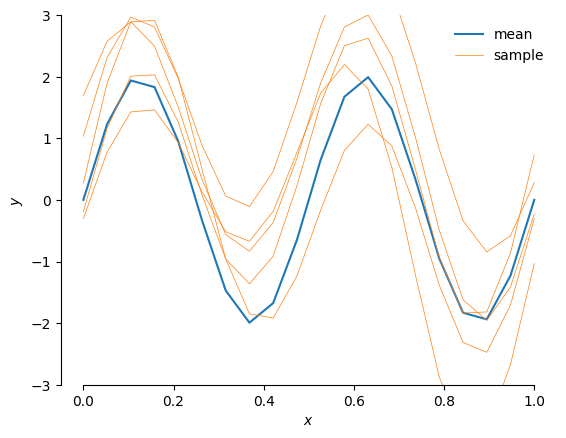

In [65]:
a = 2.0
omega = 2.0 * np.pi * 2.0
mean_func = MyMean()
mean_func.a = torch.nn.Parameter(torch.tensor([a]))
mean_func.omega = torch.nn.Parameter(torch.tensor([omega]))
k = ScaleKernel(RBFKernel())
k.base_kernel.lengthscale = 0.2
k.outputscale = 1.0
sample_functions(mean_func, k)

#### The smoothness of the sampled functions is controlled by the smoothness of the covariance function

Let’s look at the samples of a function that is not infinitely differentiable. We will use the Matérn covariance function:
$$k(x,x')=\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)^{\nu}K_{\nu}\left(\sqrt{2\nu}\frac{|x-x'|}{\ell}\right)$$

Samples from the Matérn covariance function are `cell(nu)-1` times differentiable.

Let `nu = 0.5`, we get continuous but nowhere differentiable samples.

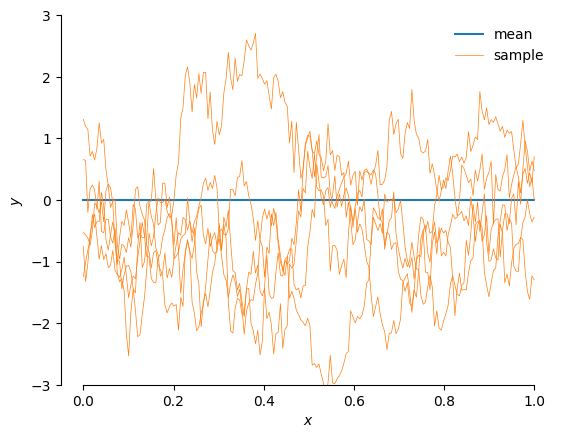

In [72]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=0.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

Compare to `mu=1.5`

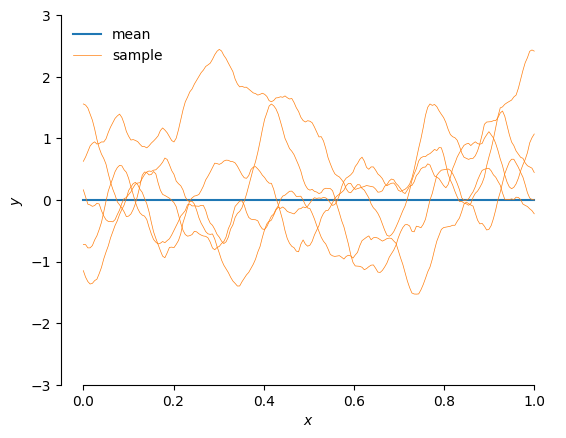

In [73]:
mean_func = ConstantMean()
k = ScaleKernel(MaternKernel(nu=1.5))
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=5, num_test=200)

#### Modeling invariances

The covariance function can also be used to model invariances. One common invariance is translation invariance:

$$f(x+\delta)=f(x),\quad\forall x\in\mathbb{R},\delta\in\mathbb{R}.$$

One can show that if the covariance function is translation invariant, then samples are also translation invariant. An example of a translation invariant covariance function is the `PeriodicKernel`:

$$k(x,x')=\exp\left\{-\frac{2}{\ell}\sin^2\left(\frac{\pi}{p}|x-x'|\right)\right\}.$$

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


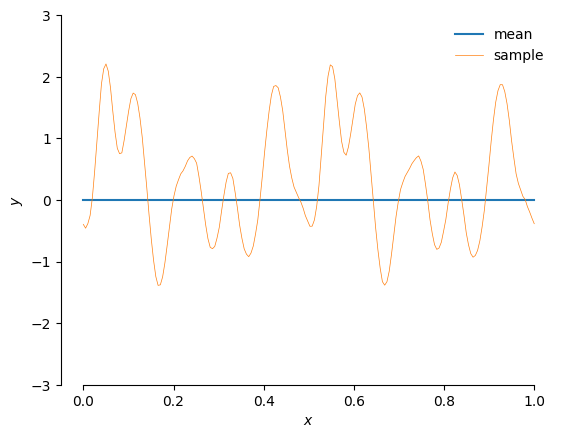

In [74]:
from gpytorch.kernels import PeriodicKernel

mean_func = ConstantMean()
k = ScaleKernel(PeriodicKernel())
print(k.base_kernel)
k.base_kernel.period_length = 0.5
k.base_kernel.lengthscale = 0.1
k.outputscale = 1.0
sample_functions(mean_func, k, num_samples=1, num_test=200, nugget=1e-4)

#### Stationary and non-stationary covariance functions

So far we have only used stationary covariance functions. A covariance function is stationary if it depends only on the distance between the inputs:

$$k(x,x')=k(|x-x'|).$$

This means that the samples from that covariance function look similar everywhere.

Sometimes, we want to model functions that are not behaving in a similar manner for all inputs. For example, they may have more wiggles in some parts of the input space than others. A classic non-stationary covariance function is the `LinearKernel`:

$$k(x,x')=vxx'$$

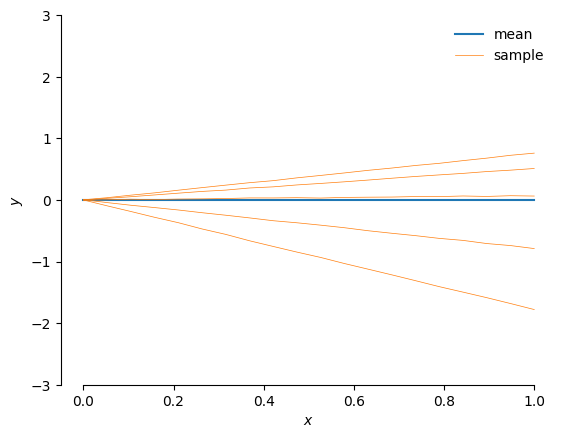

In [75]:
from gpytorch.kernels import LinearKernel

mean_func = ConstantMean()
k = LinearKernel()
k.outputscale = 1.0
sample_functions(mean_func, k)

Another classic non-stationary covariance function is the `PolynomialKernel`:

$$k(x,x')=(x^Tx'+c)^d$$

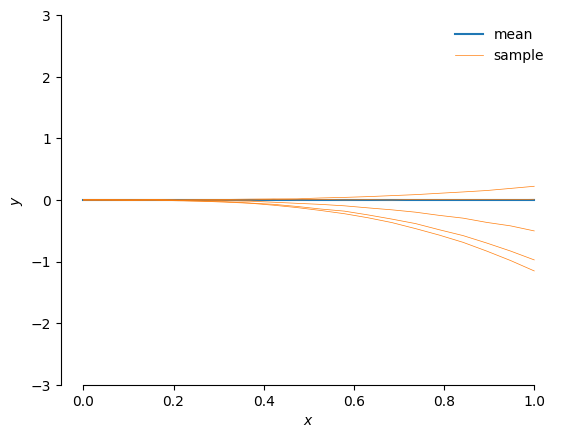

In [76]:
from gpytorch.kernels import PolynomialKernel

mean_func = ConstantMean()
k = ScaleKernel(PolynomialKernel(power=3))
k.base_kernel.offset = 0.0
k.outputscale = 1.0
sample_functions(mean_func, k)

#### Two (or more) length scales in samples

Suppose that we have a function that is the sum of two functions: one that varies slowly and one that varies quickly. How can we model this? We need to use two covariance functions: one with a small lengthscale and one with a large lengthscale. Then we need to add the two covariance functions together. Let’s see how this works.

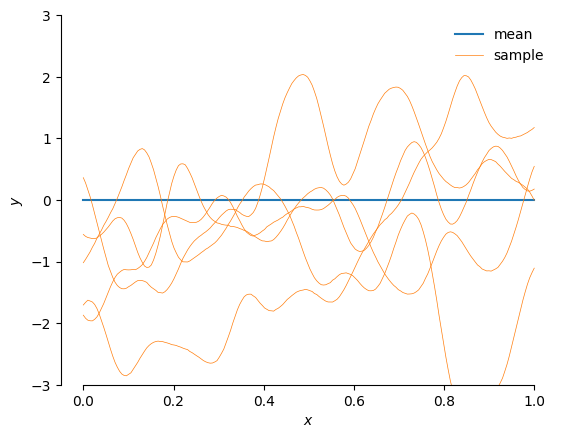

In [77]:
mean_func = ConstantMean()
kslow = ScaleKernel(RBFKernel())
kslow.base_kernel.lengthscale = 0.3
kslow.outputscale = 1.0
kfast = ScaleKernel(RBFKernel())
kfast.base_kernel.lengthscale = 0.05
kfast.outputscale = 0.4
k = kslow + kfast
sample_functions(mean_func, k, num_samples=5, num_test=200)

### Gaussian Process Regression Without Noise

https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.1.html

#### Example: GPR in 1D with fixed hyper-parameters

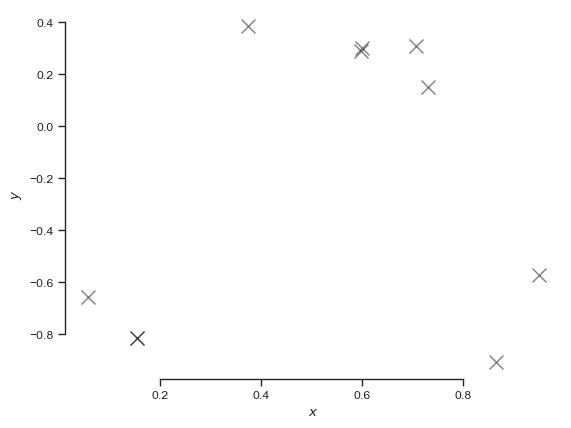

In [8]:
np.random.seed(42)

n = 10

X = np.random.rand(n)

f_true = lambda x: -np.cos(np.pi * x) * np.sin(4 * np.pi * x)
Y = f_true(X)

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, alpha=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

sns.despine(trim=True)

A GPyTorch GP model with zero mean, squard exponential covariance function and Gaussian likelihood.

In [13]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())

train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

model = ExactGP(train_x, train_y, likelihood)
print(model)

ExactGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


We are going to pick the parameters by hand in this example.

In [24]:
model.mean_module.constant = 0.0
model.covar_module.outputscale = 1.0
model.covar_module.base_kernel.lengthscale = 0.2
model.likelihood.noise = 0.0

That’s it. We have now specified the model completely. The posterior GP is completely defined. We can now make predictions from the model.

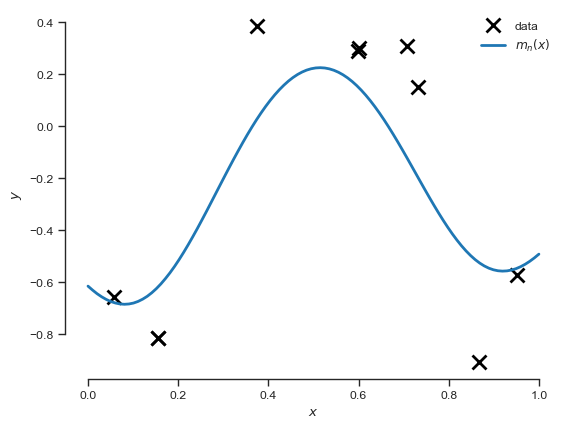

In [25]:
model.eval()
likelihood.eval()

x_star = torch.linspace(0, 1, 100).unsqueeze(-1)
f_star = model(x_star)

m_star = f_star.mean

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

This GP has not enough capacity to fit the data. Try decreasing the lengthscale.

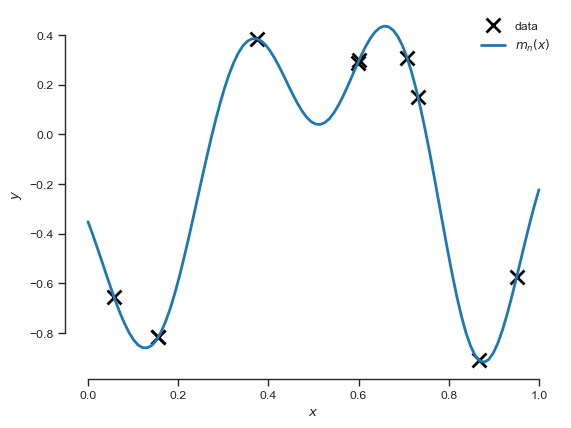

In [30]:
model.mean_module.constant = 0.0
model.covar_module.outputscale = 1.0
model.covar_module.base_kernel.lengthscale = 0.1
model.likelihood.noise = 0.0

model.eval()
likelihood.eval()

x_star = torch.linspace(0, 1, 100).unsqueeze(-1)
f_star = model(x_star)

m_star = f_star.mean

fig, ax = plt.subplots()
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

The variance on the same test points

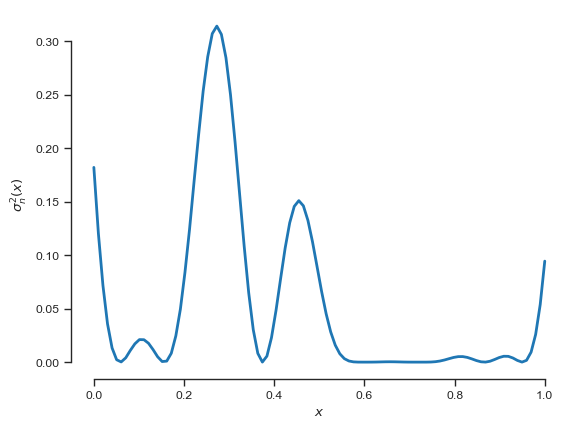

In [33]:
fig, ax = plt.subplots()
v_star = f_star.variance
ax.plot(x_star, v_star.detach(), lw=2, label="$\sigma_n^2(x)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$\sigma_n^2(x)$")
sns.despine(trim=True)

Having the posterior mean and variance, we can derive 95% predictive intervals.

$$m_n(\mathbf{x}^*))-2\sigma_n(\mathbf{x}^*)\leq f(\mathbf{x}^*)\leq m_n(\mathbf{x}^*))+2\sigma_n(\mathbf{x}^*).$$

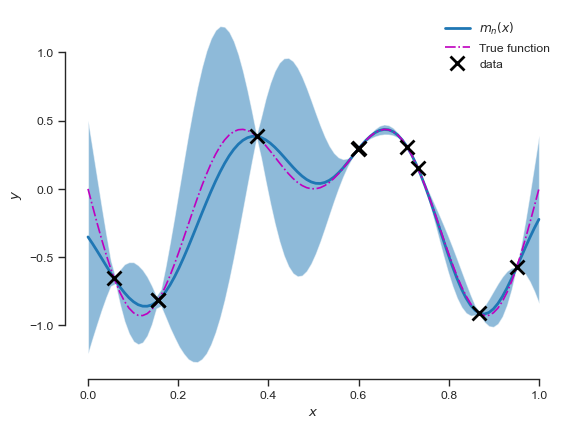

In [35]:
fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
f_lower = m_star - 2.0 * torch.sqrt(v_star)
f_upper = m_star + 2.0 * torch.sqrt(v_star)
ax.fill_between(x_star.detach().flatten(), f_lower.detach().flatten(), f_upper.detach().flatten(), alpha=0.5)
ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")
ax.plot(x_star, f_true(x_star), "m-.", label="True function")
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="data")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

We have much more information encoded in the posterior GP. It is a probability measure over the space of functions. How do we sample functions? Well, you can’t sample functions. They are infinite objects. But you can sample the function values on many test points. The joint probability density of the function values at any collection of set points is a multivariate Gaussian.

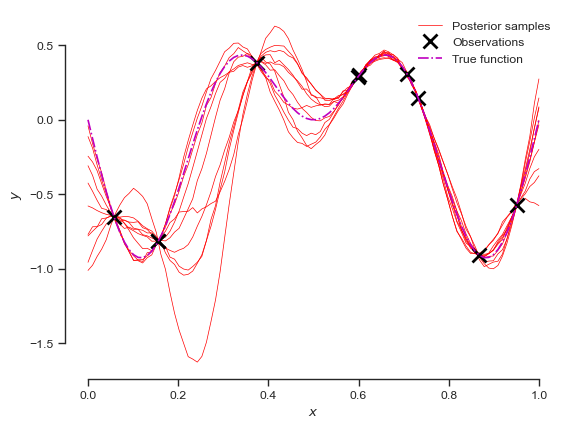

In [36]:
f_post_samples = f_star.sample(sample_shape=torch.Size([10]))

fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples.detach().T, "r", lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(X, Y, "kx", markersize=10, markeredgewidth=2, label="Observations")
ax.plot(x_star, f_true(x_star), "m-.", label="True function")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

Okay, the length scale we have assumed does not match the length scale of the actual function perfectly. But that’s how it is. In real problems, you won’t know this function anyway.

As always, it is a good idea to arrange your code in functions for reusability:

In [37]:
def plot_1d_regression(x_star, model, ax=None, f_true=None, num_samples=10):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance

    f_lower = m_star - 2.0 * torch.sqrt(v_star)
    f_upper = m_star + 2.0 * torch.sqrt(v_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x_star, m_star.detach(), lw=2, label="$m_n(x)$")

    ax.fill_between(x_star.flatten().detach(), f_lower.flatten().detach(), f_upper.flatten().detach(), alpha=0.5, label="$f(\mathbf{x}^*)$ 95% pred.")

    if f_true is not None:
        ax.plot(x_star, f_true(x_star), "m-.", label="True function")

    ax.plot(model.train_inputs[0].flatten().detach(), model.train_targets.detach(), "kx", markersize=10, markeredgewidth=2, label="Observations")

    if num_samples > 0:
        f_post_samples = f_star.sample(sample_shape=torch.Size([10]))
        ax.plot(x_star, f_post_samples.T.detach(), "r", lw=0.5)
        ax.plot([], [], "r", lw=0.5, label="Posterior samples")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    plt.legend(loc="best", frameon=False)
    sns.despine(trim=True)

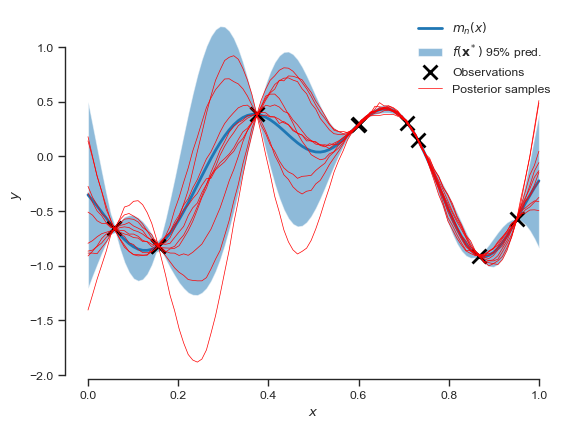

In [38]:
plot_1d_regression(x_star, model)

#### Diagnostics: How do you know if the fit is good?

To objective test the resulting model, we need a validation dataset.

##### Point-predictions

###### MSE

$$\mathrm{MSE}:=\frac{1}{n^{v}}\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-m_{n}\left(\mathbf{x}_{i}^{v}\right)\right]^{2}.$$

###### R-Squared

A somewhat intuitive measure is coefficient of determination, also known as R-squared.

$$R^{2}=1-\frac{\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-m_{n}(\mathbf{x}_{i}^{v})\right]^{2}}{\sum_{i=1}^{{n^{v}}}\left[y_{i}^{v}-\bar{y}^{v}\right]^{2}},$$


In [41]:
n_v = 100
X_v = np.random.rand(n_v)[:, None]
Y_v = f_true(X_v)


f_v = model(torch.from_numpy(X_v).float())
m_v = f_v.mean.detach().numpy()
v_v = f_v.variance.detach().numpy()
mse = np.mean((Y_v - m_v) ** 2)
print(f"MSE = {mse:1.2f}")

R2 = 1.0 - np.sum((Y_v - m_v) ** 2) / np.sum((Y_v - np.mean(Y_v)) ** 2)
print(f"R2 = {R2:1.2f}")

MSE = 0.49
R2 = -191.66


Finally, on point-predictions, we can simply plot the predictions vs the observations:

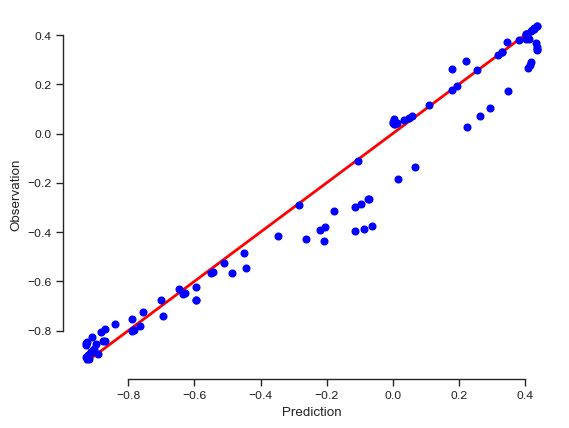

In [42]:
fig, ax = plt.subplots()
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, "r", lw=2)
ax.plot(Y_v, m_v, "bo")
ax.set_xlabel("Prediction")
ax.set_ylabel("Observation")
sns.despine(trim=True)